# 风险平价组合

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
from scipy.optimize import minimize, basinhopping
import empyrical
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
TOLERANCE = 1e-10

In [3]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [4]:
fname = '%s/assets.xlsx'%(DATA_DIR)
odf = pd.read_excel(fname, index_col=0)

In [5]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE,B.IPE,H11025.CSI,CCFI.WI
2018-09-25,3643.1047,27499.39,2915.56,182.4846,266.53,80.89,1498.4516,1141.4899
2018-09-26,3672.5872,27816.87,2905.97,182.5713,267.10,81.18,1498.5793,1144.5826
2018-09-27,3639.5767,27715.67,2914.00,182.6896,266.30,81.30,1498.7054,1130.0561
2018-09-28,3674.7587,27788.52,2913.98,182.7727,264.06,82.95,1498.8410,1133.5169
2018-10-08,3535.0847,26202.57,2884.43,183.0077,266.98,83.76,1498.8410,1148.9252


# 标准风险平价

In [6]:
def _allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]
    
    # It returns the risk of the weights distribution
    return portfolio_risk

In [7]:
def _assets_risk_contribution_to_allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)
    
    # calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) / portfolio_risk
    
    # It returns the contribution of each asset to the risk of the weights distribution
    return assets_risk_contribution

In [8]:
def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the weights distribution
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error

In [9]:
def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):
    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})
    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

# 用样本协方差计算风险平价组合权重

In [10]:
df = odf[['881001.WI', 'HSI.HI', 'SPX.GI', 'CBA00101.CS', 'AU9999.SGE']]

In [11]:
df = df.replace([0], np.NAN)

In [12]:
ret_df = df.pct_change().dropna()

### 过去一年协方差

In [13]:
covariances = ret_df.iloc[-242:].cov()

In [14]:
empyrical.annual_volatility(ret_df['SPX.GI'])

0.18452070943486634

### 计算权重

In [15]:
n = df.shape[1]
init_weights = np.array([1. / n] * n)
assets_risk_budget = np.array([1./9, 1./9, 1./9, 1./3, 1./3])
# assets_risk_budget = np.array([1. / n] * n)

In [16]:
assets_risk_budget

array([0.11111111, 0.11111111, 0.11111111, 0.33333333, 0.33333333])

### 等权下的风险贡献

In [17]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(init_weights), covariances.values)

In [18]:
rc

matrix([[ 1.96766950e-03],
        [ 1.97518880e-03],
        [ 7.15679351e-04],
        [-1.25220915e-05],
        [ 1.22799004e-04]])

### 风险权重相等

In [19]:
weights = _get_risk_parity_weights(covariances.values*1e7, assets_risk_budget, init_weights)

In [20]:
weights

array([0.02267366, 0.02221989, 0.03681413, 0.78120197, 0.13709034])

In [21]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)

In [22]:
rc

matrix([[0.00010664],
        [0.00010664],
        [0.00010664],
        [0.00031992],
        [0.00031992]])

In [23]:
abs((rc / rc.sum() - assets_risk_budget).sum()) < TOLERANCE

True

# 回测

In [24]:
new_df = df[(df.index >= ret_df.index[0]) & (df.index <= ret_df.index[-1])]

In [25]:
new_df.head()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE
2002-10-31,1089.3016,9441.25,885.76,102.8093,83.91
2002-11-01,1090.0460,9407.68,900.96,102.5936,84.51
2002-11-04,1106.8153,9720.83,908.35,102.8225,84.99
2002-11-05,1126.3690,9655.36,915.39,102.7488,85.13
2002-11-06,1121.7200,9773.98,923.76,102.8338,84.90


In [26]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
n, k = new_df.shape[1], 242
wb = np.zeros(n)
assets_risk_budget = np.array([1./9, 1./9, 1./9, 1./3, 1./3])
init_weights = np.array([1. / n] * n)
for date in new_df.index:
    weight.loc[date] = wb
    if date.dayofweek == 4:
        past_return = ret_df[ret_df.index <= date][-k:]
        if past_return.shape[0] == k:
            covariances = past_return.cov()
            temp = wb.copy()
            wb = _get_risk_parity_weights(covariances.values*1e7, assets_risk_budget, init_weights)
            # check risk contribution
            rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)
            if abs((rc / rc.sum() - assets_risk_budget).sum()) > TOLERANCE:
                print(date)
                wb = temp.copy()

In [27]:
weight.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE
2018-09-25,0.0227595,0.0223006,0.036839,0.779992,0.138109
2018-09-26,0.0227595,0.0223006,0.036839,0.779992,0.138109
2018-09-27,0.0227595,0.0223006,0.036839,0.779992,0.138109
2018-09-28,0.0227595,0.0223006,0.036839,0.779992,0.138109
2018-10-08,0.0227081,0.0222932,0.0368517,0.781187,0.13696


In [28]:
portfolio_ret = (weight * ret_df).sum(axis=1)
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [29]:
weight_plot = weight.drop_duplicates().iloc[1:].astype(np.float32)

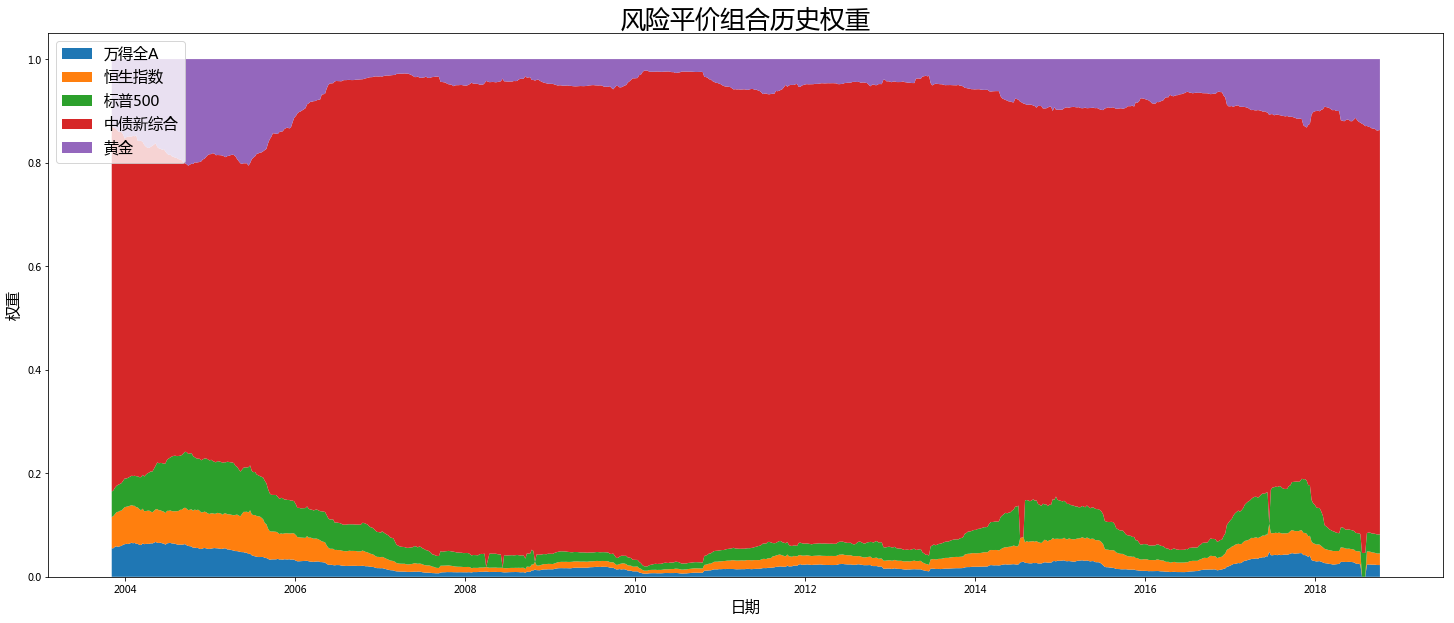

In [30]:
fig, ax = plt.subplots(figsize=(25, 10))
_ = ax.stackplot(weight_plot.index, 
                 weight_plot['881001.WI'],
                 weight_plot['HSI.HI'],
                 weight_plot['SPX.GI'],
                 weight_plot['CBA00101.CS'],
                 weight_plot['AU9999.SGE'], 
                 labels=[u'万得全A', u'恒生指数', u'标普500', u'中债新综合', u'黄金'])
ax.legend(loc='upper left', fontsize=15)
ax.set_title(u'风险平价组合历史权重', fontsize=25)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
fig.savefig('../pic/portfolio_weight.jpg', dpi=200, bbox_inches='tight')

In [31]:
metric(portfolio_ret)

Annual return: 4.92%
Sharpe ratio: 2.17
Annual volatility: 2.22%
Max drawdown: -4.70%


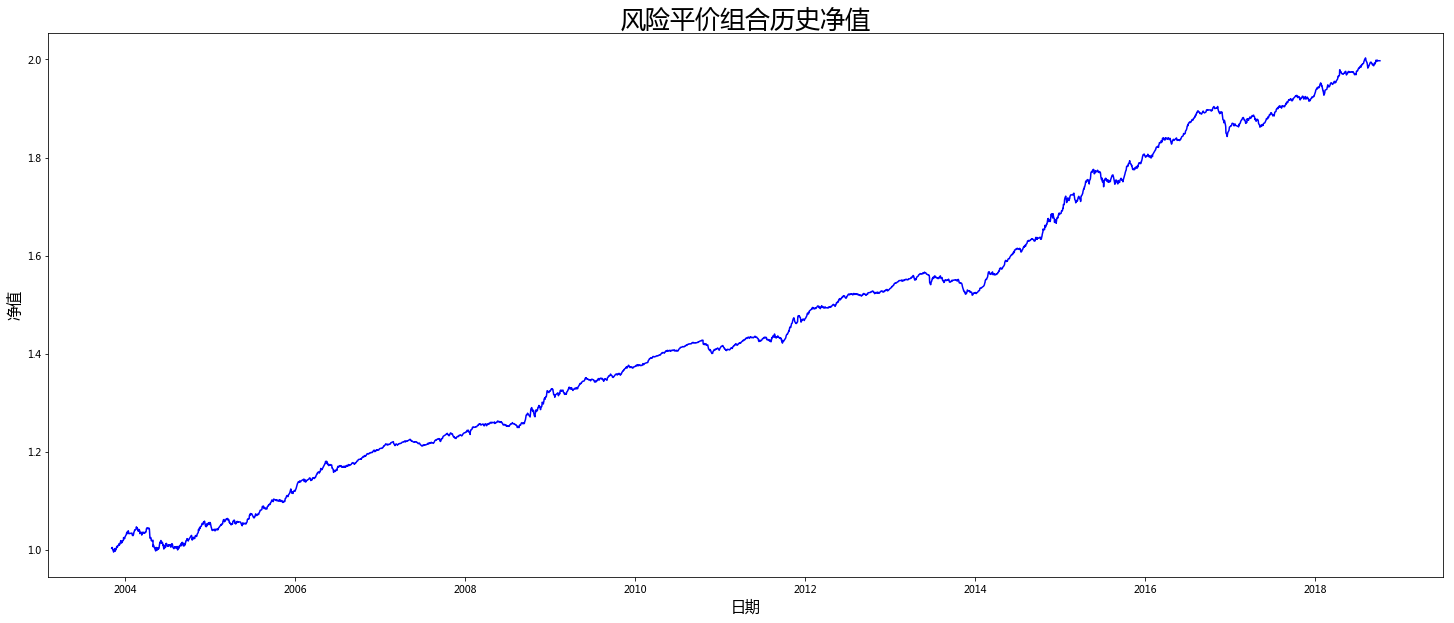

In [32]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot((1 + portfolio_ret).cumprod(), color='blue')
ax.set_title(u'风险平价组合历史净值', fontsize=25)
ax.set_ylabel(u'净值', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
fig.savefig('../pic/portfolio_return.jpg', dpi=200, bbox_inches='tight')

# 今年以来风险平价组合与各类资产情况

In [33]:
fname = u'../data/stats.xlsx'

In [34]:
workbook = xlsxwriter.Workbook(fname)
worksheet = workbook.add_worksheet()

In [35]:
col_format = workbook.add_format({'bold': True, 'align': 'center', 'font_name': u'楷体', 'font_color': '#FFFFFF', 'bg_color': '#993333'})
cell_format = workbook.add_format({'font_name': u'楷体'})
percent_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00%'})
number_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00'})

In [36]:
worksheet.write('A1', '', col_format)
worksheet.write('B1', u'收益率', col_format)
worksheet.write('C1', u'波动率', col_format)
worksheet.write('D1', u'夏普率', col_format)
worksheet.write('E1', u'当前权重', col_format)
worksheet.write('F1', u'风险贡献', col_format)

0

In [37]:
weights = weight.iloc[-1]

In [38]:
worksheet.write('A2', u'万得全A', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['881001.WI']
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['881001.WI']
rc = assets_risk_budget[0]
worksheet.write('B2', ret, percent_format)
worksheet.write('C2', vol, percent_format)
worksheet.write('D2', sh, number_format)
worksheet.write('E2', w, percent_format)
worksheet.write('F2', rc, percent_format)

0

In [39]:
worksheet.write('A3', u'恒生指数', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['HSI.HI']
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['HSI.HI']
rc = assets_risk_budget[1]
worksheet.write('B3', ret, percent_format)
worksheet.write('C3', vol, percent_format)
worksheet.write('D3', sh, number_format)
worksheet.write('E3', w, percent_format)
worksheet.write('F3', rc, percent_format)

0

In [40]:
worksheet.write('A4', u'标普500', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['SPX.GI']
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['SPX.GI']
rc = assets_risk_budget[2]
worksheet.write('B4', ret, percent_format)
worksheet.write('C4', vol, percent_format)
worksheet.write('D4', sh, number_format)
worksheet.write('E4', w, percent_format)
worksheet.write('F4', rc, percent_format)

0

In [41]:
worksheet.write('A5', u'中债新综合', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['CBA00101.CS']
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['CBA00101.CS']
rc = assets_risk_budget[3]
worksheet.write('B5', ret, percent_format)
worksheet.write('C5', vol, percent_format)
worksheet.write('D5', sh, number_format)
worksheet.write('E5', w, percent_format)
worksheet.write('F5', rc, percent_format)

0

In [42]:
worksheet.write('A6', u'黄金', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['AU9999.SGE']
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
w = weights['AU9999.SGE']
sh = empyrical.sharpe_ratio(s)
rc = assets_risk_budget[4]
worksheet.write('B6', ret, percent_format)
worksheet.write('C6', vol, percent_format)
worksheet.write('D6', sh, number_format)
worksheet.write('E6', w, percent_format)
worksheet.write('F6', rc, percent_format)

0

In [43]:
worksheet.write('A7', u'现金', cell_format)
s = odf[odf.index >= '2018-01-01']['H11025.CSI'].pct_change()
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
worksheet.write('B7', ret, percent_format)
worksheet.write('C7', vol, percent_format)
worksheet.write('D7', sh, number_format)
worksheet.write('E7', 0, percent_format)
worksheet.write('F7', 0, percent_format)

0

In [44]:
worksheet.write('A8', u'风险平价组合', cell_format)
s = portfolio_ret[portfolio_ret.index >= '2018-01-01']
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
worksheet.write('B8', ret, percent_format)
worksheet.write('C8', vol, percent_format)
worksheet.write('D8', sh, number_format)
worksheet.write('E8', 1, percent_format)
worksheet.write('F8', 1, percent_format)

0

In [45]:
worksheet.set_column(0, 0, 15)

0

In [46]:
workbook.close()